# 作业02：Fashion Mnist实现图像分类

## 1 概述
Fashion-MNIST是一个替代MNIST手写数字集的图像数据集，它是由Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自10种类别的共7万个不同商品的正面图片。Fashion-MNIST的大小、格式和训练集/测试集划分与原始的MNIST完全一致。数据集按照60000/10000的比例进行训练测试数据划分，全部数据均为28x28的灰度图片。

**基本要求**：
1. 使用卷积神经网络完成Fashion-MNIST的分类任务。
2. 在README文件中描述所使用的模型的结构、优化器、损失函数和超参数等信息，以及模型在训练集和测试集上的最优结果。
3. 对模型中训练过程损失函数的变化趋势可视化

**加分项**：可以对模型进行优化（包括增加层数，使用残差连接，调整超参数等），或者对模型的训练过程/结果进行可视化（例如模型损失函数在训练过程中的变化趋势，或者参数的分布随训练批次的变化趋势等）。

## 2. 实现模型

### 2.1 数据集加载
可以通过飞桨自带的`paddle.vision.dataset`进行数据集加载，并且通过`paddle.vision.transforms`对数据进行预处理，例如对数据进行归一化。

In [1]:
import paddle
print(paddle.__version__)

import paddle.vision.transforms as T
print("Paddle版本号为："+paddle.__version__)

transform = T.Compose([T.Normalize(mean=[127.5],
                                   std=[127.5],
                                   data_format='CHW')])

# 对数据进行归一化
train_dataset = paddle.vision.datasets.FashionMNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.FashionMNIST(mode='test', transform=transform)

2.1.2
Paddle版本号为：2.1.2


Cache file /home/aistudio/.cache/paddle/dataset/fashion-mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/fashion_mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/fashion-mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/fashion_mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file /home/aistudio/.cache/paddle/dataset/fashion-mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/fashion_mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/fashion-mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/fashion_mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


### 2.2 模型搭建

使用paddle的接口搭建神经网络模型。以LeNet模型为例，该模型与1998年提出，包含了深度学习图像处理相关的基本模块。

LeNet模型一共有7层，包括2个**卷积层**，2个**池化层**和3个**全连接层**。通过连续使用卷积层和池化层提取图像特征。Paddle中提供了相应的接口，可以快速搭建网络模型：
1. 卷积层：`paddle.nn.Conv2D`；
2. 池化层：`paddle.nn.MaxPool2D`；
3. 全连接层：`paddle.nn.Linear`。

### **作业要求**：搭建神经网络，完成`__init__`和`forward`函数，并在README文件中详细描述所使用模型的信息。

In [2]:
import paddle.nn.functional as F
import paddle.nn as nn
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        # 搭建网络
        self.conv1 = nn.Conv2D(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2)
        self.max_pool1 = nn.MaxPool2D(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2D(in_channels=6,out_channels=16,kernel_size=5,stride=1)
        self.max_pool2 = nn.MaxPool2D(kernel_size=2,stride=2)
        self.linear1 = nn.Linear(in_features=16*5*5,out_features=120)
        self.linear2 = nn.Linear(in_features=120,out_features=84)
        self.linear3 = nn.Linear(in_features=84,out_features=10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1 , stop_axis=-1) # [16,5,5] -> [16*5*5]
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

#模型网络结构可视化
leNet = LeNet()
paddle.summary(leNet, (-1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 1, 28, 28]]      [1, 6, 28, 28]          156      
  MaxPool2D-1     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-2       [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
  MaxPool2D-2    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Linear-1          [[1, 400]]            [1, 120]           48,120     
   Linear-2          [[1, 120]]            [1, 84]            10,164     
   Linear-3          [[1, 84]]             [1, 10]              850      
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
-----------------------------------------------------------------------

{'total_params': 61706, 'trainable_params': 61706}

## 3. 模型配置与训练
可以使用`Model`搭建实例，然后使用`model.prepare`接口进行模型的配置，比如优化器、损失函数和评价指标等，也可以使用其他方法配置和训练模型。

In [3]:
model = paddle.Model(LeNet()) # 用Model封装模型

learning_rate = 0.001
weight_decay = 5e-4
num_epochs = 50

### **作业要求**：完成训练过程可视化的相关函数，训练模型并保存可视化结果。

In [4]:
import matplotlib.pyplot as plt

def DrawLossFunction(y):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("iters", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    x = [idx for idx in range(len(y))]
    plt.plot(x, y,color='red',label='training loss') 
    plt.grid()
    plt.show()

def DrawAccuracy(y):
    title="training accuracy"
    plt.title(title, fontsize=24)
    plt.xlabel("epoch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    x = [idx for idx in range(len(y))]
    plt.plot(x, y,color='red',label='training acc') 
    plt.grid()
    plt.show()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


epoch: 0, batch_id: 0, loss is: [2.7550159], acc is: [0.078125]
epoch: 0, batch_id: 300, loss is: [0.4777534], acc is: [0.796875]
epoch: 0, batch_id: 600, loss is: [0.2829248], acc is: [0.921875]
epoch: 0, batch_id: 900, loss is: [0.24119134], acc is: [0.9375]
epoch: 1, batch_id: 0, loss is: [0.26564908], acc is: [0.890625]
epoch: 1, batch_id: 300, loss is: [0.40073696], acc is: [0.84375]
epoch: 1, batch_id: 600, loss is: [0.27481028], acc is: [0.921875]
epoch: 1, batch_id: 900, loss is: [0.31328732], acc is: [0.90625]
epoch: 2, batch_id: 0, loss is: [0.3933179], acc is: [0.859375]
epoch: 2, batch_id: 300, loss is: [0.19875698], acc is: [0.890625]
epoch: 2, batch_id: 600, loss is: [0.19362886], acc is: [0.921875]
epoch: 2, batch_id: 900, loss is: [0.3591938], acc is: [0.90625]
epoch: 3, batch_id: 0, loss is: [0.3270799], acc is: [0.875]
epoch: 3, batch_id: 300, loss is: [0.21550266], acc is: [0.921875]
epoch: 3, batch_id: 600, loss is: [0.08306415], acc is: [1.]
epoch: 3, batch_id: 900

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


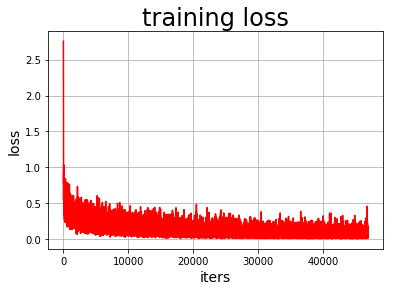

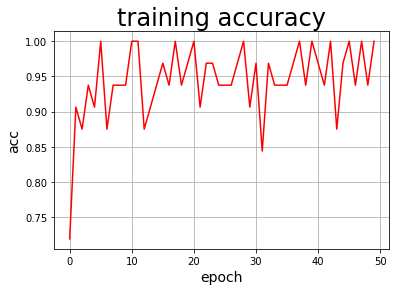

In [5]:
import paddle.nn.functional as F
from visualdl import LogWriter
import paddle.fluid as fluid

train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)
# 加载训练集 batch_size 设为 64
train_loss_arr = []
acc_arr = []
def train(model):
    with LogWriter(logdir='./log/train') as writer:
        # with fluid.dygraph.guard(place=fluid.CUDAPlace(0)):
        model.train()
        epochs = num_epochs
        # optim = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters(),weight_decay=weight_decay)
        optim = paddle.optimizer.Adam(learning_rate=learning_rate, parameters=model.parameters(),weight_decay=weight_decay)
        loss = 0
        acc = 0
        Batch = 0

        param = model.parameters()
        params_name = [param.name for param in model.parameters()]

        # 用Adam作为优化函数
        for epoch in range(epochs):
            for batch_id, data in enumerate(train_loader()):
                x_data = data[0]
                y_data = data[1]
                predicts = model(x_data)
                loss = F.cross_entropy(predicts, y_data)
                train_loss_arr.append(loss[0].item())
                # 计算损失
                acc = paddle.metric.accuracy(predicts, y_data)
                loss.backward()
                if batch_id % 300 == 0:
                    Batch += 1
                    # histogram组件
                    for name_i in range(len(params_name)):
                        writer.add_histogram(tag=params_name[name_i], values=param[name_i].numpy(), step=Batch)
                    
                    print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, loss.numpy(), acc.numpy()))
                optim.step()
                optim.clear_grad()
            acc_arr.append(acc.numpy())
            

model = LeNet()
train(model)
DrawLossFunction(train_loss_arr)
DrawAccuracy(acc_arr)

In [6]:
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
# 加载测试数据集
def test(model):
    model.eval()
    batch_size = 64
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        # 获取预测结果
        loss = F.cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        if batch_id % 20 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id, loss.numpy(), acc.numpy()))
test(model)

batch_id: 0, loss is: [0.46367842], acc is: [0.875]
batch_id: 20, loss is: [0.9190521], acc is: [0.859375]
batch_id: 40, loss is: [0.47752765], acc is: [0.890625]
batch_id: 60, loss is: [0.7083974], acc is: [0.859375]
batch_id: 80, loss is: [0.37330002], acc is: [0.875]
batch_id: 100, loss is: [0.27477604], acc is: [0.921875]
batch_id: 120, loss is: [0.16527501], acc is: [0.953125]
batch_id: 140, loss is: [0.20160635], acc is: [0.9375]
